<a href="https://colab.research.google.com/github/shazzad-hasan/ethereum-fraud-detection/blob/main/models/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.base import TransformerMixin, BaseEstimator
from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(123)

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/combined_kaggle_etherscan_ts_data.csv').drop(columns=['Unnamed: 0'])

feature_list = list(set(df.columns) - set(['Address', 'FLAG']))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['FLAG'])

In [4]:
print("Number of training samples: ", df_train.shape[0])
print("Number of Test samples: ", df_test.shape[0])

Number of training samples:  11136
Number of Test samples:  2784


In [5]:
%run "/content/drive/MyDrive/ethereum-fraud-detection/models/helper_data_preprocessing.py"

In [6]:
dp = DataPrep(
    features=feature_list,
    fill_strategy='median',
    upper_clip_quantile=0.95,
    lower_clip_quantile=0.05
)

In [7]:
df_train_prep = dp.fit_transform(df_train)
df_test_prep = dp.transform(df_test)

In [8]:
scaler = StandardScaler()
df_train_prep = scaler.fit_transform(df_train_prep[feature_list])
df_test_prep = scaler.transform(df_test_prep[feature_list])

In [9]:
xgb = XGBClassifier(seed=42)

params = {
    'objective': ['reg:squarederror', 'binary:logistic'],
    'max_depth': [2, 4, 6],
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.3, 0.5, 0.7],
    'colsample_bytree':[0.3, 0.5, 0.7]
}

clf = GridSearchCV(estimator=xgb,
                   param_grid=params,
                   cv=5,
                   n_jobs=-1,
                   scoring='f1')
clf.fit(df_train_prep, df_train['FLAG'])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.1], 'max_depth': [2, 4, 6],
                         'n_estimators': [500, 1000, 1500],
                         'objective': ['reg:squarederror', 'binary:logistic'],
                         'subsample': [0.3, 0.5, 0.7]},
             scoring='f1')

In [10]:
print("Tuned Hyperparameters :", clf.best_params_)

Tuned Hyperparameters : {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000, 'objective': 'binary:logistic', 'subsample': 0.5}


In [11]:
print('train roc_auc_score: ', roc_auc_score(df_train['FLAG'], clf.predict_proba(df_train_prep)[:, 1]))
print('test roc_auc_score: ', roc_auc_score(df_test['FLAG'], clf.predict_proba(df_test_prep)[:, 1]))

train roc_auc_score:  0.9999999511541621
test roc_auc_score:  0.9875281267078557


In [12]:
y_pred = clf.predict(df_test_prep)
y_prob = clf.predict_proba(df_test_prep)[:, 1]

precision, recall, thresholds = precision_recall_curve(df_test['FLAG'], y_prob)

print("Precision: {}\nRecall: {}\nAccuracy: {}\nF1 Score: {}".format(
    precision_score(df_test['FLAG'], y_pred),
    recall_score(df_test['FLAG'], y_pred),
    accuracy_score(df_test['FLAG'], y_pred),
    f1_score(df_test['FLAG'], y_pred))
)

pr_data = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'thresholds': list(thresholds) + [1.0]
})
pr_data.to_csv('/content/drive/MyDrive/ethereum-fraud-detection/results/precision_recall_data_xgboost.csv', index=False)

Precision: 0.942741935483871
Recall: 0.9299920445505171
Accuracy: 0.9428879310344828
F1 Score: 0.9363235883059672


              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1527
           1       0.94      0.93      0.94      1257

    accuracy                           0.94      2784
   macro avg       0.94      0.94      0.94      2784
weighted avg       0.94      0.94      0.94      2784



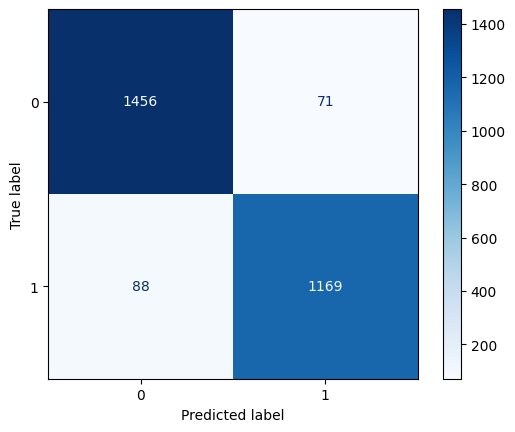

In [13]:
print(classification_report(df_test['FLAG'], y_pred))

cm = confusion_matrix(df_test['FLAG'], y_pred)
cmap = sns.color_palette("Blues", as_cmap=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=cmap)
plt.show()

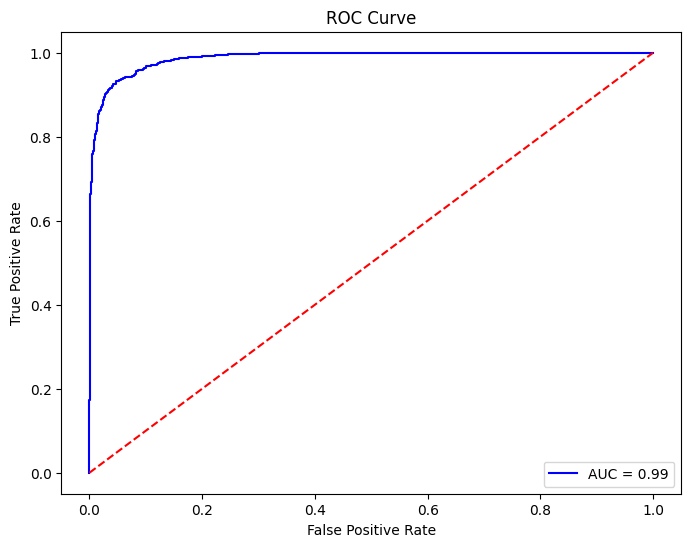

In [14]:
fpr, tpr, threshold = roc_curve(df_test['FLAG'], y_prob)
roc_auc = auc(fpr, tpr)

roc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_data.to_csv('/content/drive/MyDrive/ethereum-fraud-detection/results/roc_data_xgboost.csv', index=False)

plt.figure(figsize=(8,6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

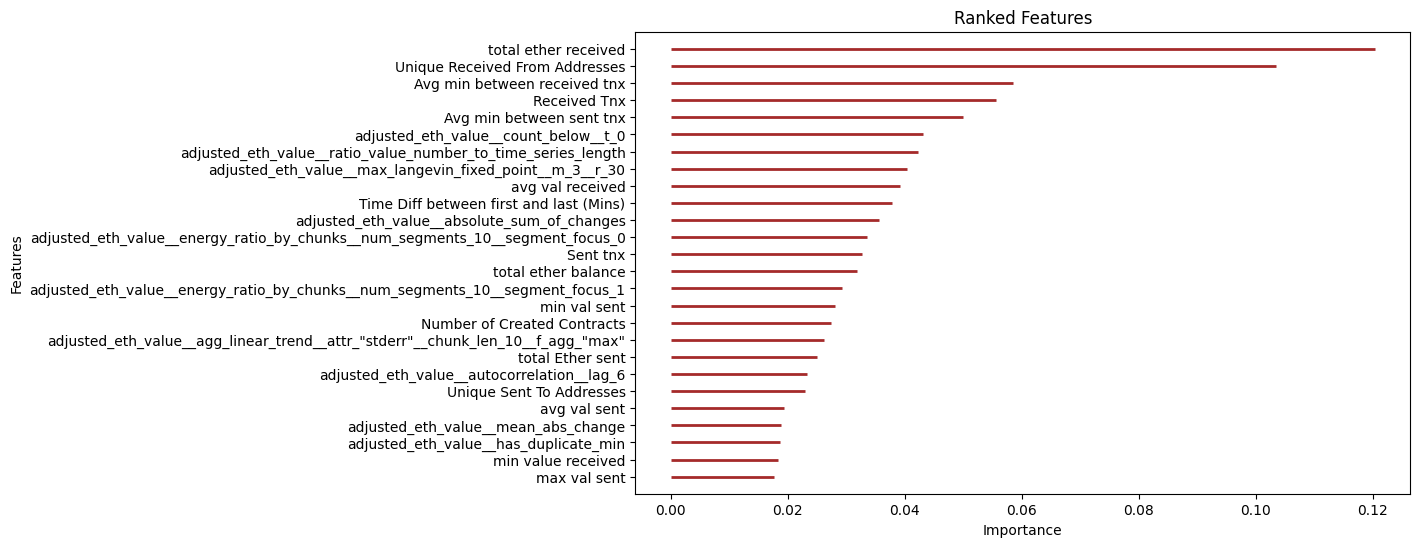

In [15]:
feat_importances = clf.best_estimator_.feature_importances_
indices = np.argsort(feat_importances)

fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked Features")
y_positions = range(len(feat_importances))
plt.hlines(y=y_positions, xmin=0, xmax=feat_importances[indices], color='brown', linewidth=2)
features = ['{}'.format(feature_list[i]) for i in range(len(feature_list))]
plt.yticks(y_positions, [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

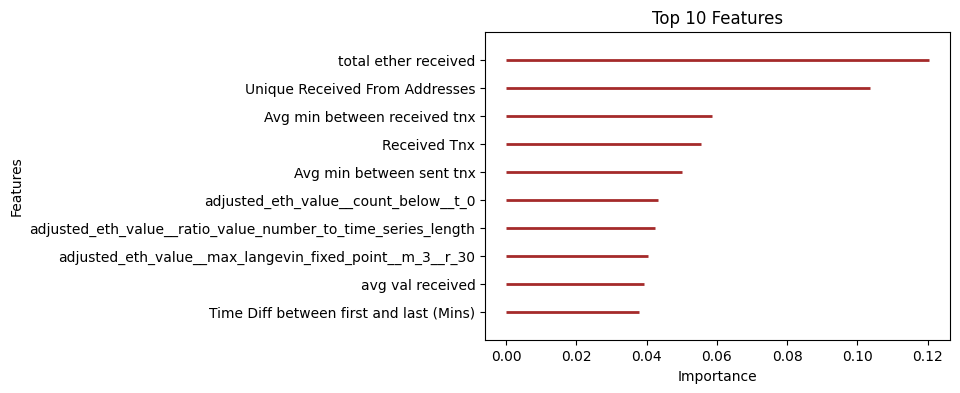

In [18]:
top_10_indices = indices[-10:]

fig, ax = plt.subplots(figsize=(6,4))
plt.title("Top 10 Features")
y_positions = range(len(top_10_indices))
plt.hlines(y=y_positions, xmin=0, xmax=feat_importances[top_10_indices], color='brown', linewidth=2)
features = ['{}'.format(feature_list[i]) for i in range(len(feature_list))]
plt.yticks(y_positions, [features[idx] for idx in top_10_indices])
plt.ylim([-1, len(top_10_indices)])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [17]:
# Save the model
pickle_out = open('/content/drive/MyDrive/ethereum-fraud-detection/saved-models/XGBoost.pickle', 'wb')
pickle.dump(clf, pickle_out)
pickle_out.close()